In [1]:
!pip install sacrebleu
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import sacrebleu
import json
import matplotlib.pyplot as plt
import csv
import re





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 10.1 MB/s eta 0:00:00


In [14]:
import json
import re
import torch

# Function to clean invalid escape sequences
def clean_json(file_path):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        content = f.read()
    # Remove invalid \uXXXX sequences
    content = re.sub(r'\\u[0-9A-Fa-f]{0,3}(?![0-9A-Fa-f])', '', content)
    return content

# Load and clean JSON
file_path = '/content/Japanes.json'
try:
    cleaned_content = clean_json(file_path)
    data = json.loads(cleaned_content)
    print("JSON loaded successfully.")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")

# Extract sentences
en_sentences = [entry['input'] for entry in data[:1000]]
ja_sentences = [entry['output'] for entry in data[:1000]]  # Lowercase 'bu_sentences'


JSON loaded successfully.


In [27]:

# Hyperparameters
MAX_LEN = 60
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VOCAB_SIZE = 200000
EMBEDDING_DIM = 256
HIDDEN_DIM = 512
BATCH_SIZE = 32
NUM_EPOCHS = 20

tokenizer = lambda x: x.split()

# Build vocabulary
def build_vocab(sentences):
    counter = {}
    for sentence in sentences:
        for token in tokenizer(sentence):
            counter[token] = counter.get(token, 0) + 1
    return {word: idx + 4 for idx, (word, _) in enumerate(counter.items())}

en_vocab = {'<pad>': 0, '<s>': 1, '</s>': 2, '<unk>': 3, **build_vocab(en_sentences)}
ja_vocab = {'<pad>': 0, '<s>': 1, '</s>': 2, '<unk>': 3, **build_vocab(ja_sentences)}  # Lowercase 'ja_sentences'

# Convert sentences to tensors
def sentence_to_tensor(sentence, vocab, max_len=MAX_LEN):
    tokens = [vocab.get(word, vocab['<unk>']) for word in tokenizer(sentence)]
    return torch.tensor([vocab['<s>']] + tokens + [vocab['</s>']] + [vocab['<pad>']] * (max_len - len(tokens) - 2))[:max_len]

en_tensor_sentences = [sentence_to_tensor(s, en_vocab) for s in en_sentences]
ja_tensor_sentences = [sentence_to_tensor(s, ja_vocab) for s in ja_sentences]  # Lowercase 'ja_tensor_sentences'

# Split into training and validation sets
train_size = int(len(en_tensor_sentences) * 0.8)
train_en, val_en = en_tensor_sentences[:train_size], en_tensor_sentences[train_size:]
train_ja, val_ja = ja_tensor_sentences[:train_size], ja_tensor_sentences[train_size:]  # Lowercase 'train_bu' and 'val_bu'


In [28]:
def print_sample_data(en_sentences, bu_sentences):
    for i in range(4):
        en_sample, bu_sample = en_sentences[i], bu_sentences[i]
        print(f"EN to Ja\n<s>\n<en> {en_sample} </en>\n<ja> {bu_sample} </ja>\n</s>")
        print(f"Ja to EN\n<s>\n<ja> {bu_sample} </ja>\n<en> {en_sample} </en>\n</s>\n")

# Call the function with English and Japanes sentences
print_sample_data(en_sentences, bu_sentences)


EN to Ja
<s>
<en> Give three tips for staying healthy. </en>
<ja> 健康を維持するための3つのヒントを教えてください。 </ja>
</s>
Ja to EN
<s>
<ja> 健康を維持するための3つのヒントを教えてください。 </ja>
<en> Give three tips for staying healthy. </en>
</s>

EN to Ja
<s>
<en> 1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.

2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.

3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night. </en>
<ja>  1. バランスの

In [29]:
class TranslationDataset(Dataset):
    def __init__(self, en, bu):
        self.en, self.te = en, bu
    def __len__(self):
        return len(self.en)
    def __getitem__(self, idx):
        return self.en[idx], self.te[idx]

def collate_fn(batch):
    en_batch, te_batch = zip(*batch)
    return torch.stack(en_batch, dim=0), torch.stack(te_batch, dim=0)

train_loader = DataLoader(TranslationDataset(train_en, train_ja), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(TranslationDataset(val_en, val_ja), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


In [30]:
import pandas as pd

# LSTM-based Model for Translation with more layers
class LSTMTranslationModel(nn.Module):
    def __init__(self, input_dim, output_dim, embed_dim, hidden_dim, num_layers=2):
        super(LSTMTranslationModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, te_input=None):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        output = self.fc(lstm_out)
        return output

# Initialize Model
model = LSTMTranslationModel(input_dim=VOCAB_SIZE, output_dim=len(ja_vocab), embed_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM).to(DEVICE)


def custom_model_summary(model):
    # Extract model details
    model_summary = []
    for name, param in model.named_parameters():
        layer_info = {
            "Layer Name": name,
            "Layer Type": type(param).__name__,
            "Output Shape": list(param.size()),
            "Parameters": param.numel()
        }
        model_summary.append(layer_info)

    # Display as a DataFrame table
    df_summary = pd.DataFrame(model_summary)
    print(df_summary.to_markdown(index=False))

custom_model_summary(model)


| Layer Name        | Layer Type   | Output Shape   |   Parameters |
|:------------------|:-------------|:---------------|-------------:|
| embedding.weight  | Parameter    | [200000, 256]  |     51200000 |
| lstm.weight_ih_l0 | Parameter    | [2048, 256]    |       524288 |
| lstm.weight_hh_l0 | Parameter    | [2048, 512]    |      1048576 |
| lstm.bias_ih_l0   | Parameter    | [2048]         |         2048 |
| lstm.bias_hh_l0   | Parameter    | [2048]         |         2048 |
| lstm.weight_ih_l1 | Parameter    | [2048, 512]    |      1048576 |
| lstm.weight_hh_l1 | Parameter    | [2048, 512]    |      1048576 |
| lstm.bias_ih_l1   | Parameter    | [2048]         |         2048 |
| lstm.bias_hh_l1   | Parameter    | [2048]         |         2048 |
| fc.weight         | Parameter    | [3529, 512]    |      1806848 |
| fc.bias           | Parameter    | [3529]         |         3529 |


In [31]:
# Define Optimizer and Loss Function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=ja_vocab['<pad>'])

def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for en_batch, te_batch in train_loader:
            en_batch, te_batch = en_batch.to(DEVICE), te_batch.to(DEVICE)
            te_batch = te_batch.long()
            optimizer.zero_grad()
            output = model(en_batch)
            loss = criterion(output.reshape(-1, output.shape[-1]), te_batch.reshape(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for en_batch, te_batch in val_loader:
                en_batch, te_batch = en_batch.to(DEVICE), te_batch.to(DEVICE)
                output = model(en_batch)
                loss = criterion(output.reshape(-1, output.shape[-1]), te_batch.reshape(-1))
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')

    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=NUM_EPOCHS)

torch.save(model.state_dict(), 'lstm_translation_model.pth')

Epoch 1/20, Train Loss: 6.669412956237793, Val Loss: 5.717513118471418
Epoch 2/20, Train Loss: 5.507481346130371, Val Loss: 5.990183251244681
Epoch 3/20, Train Loss: 5.257644233703613, Val Loss: 6.248048169272287
Epoch 4/20, Train Loss: 5.053595180511475, Val Loss: 6.469724587031773
Epoch 5/20, Train Loss: 4.872624206542969, Val Loss: 6.725061961582729
Epoch 6/20, Train Loss: 4.583933629989624, Val Loss: 6.803114891052246
Epoch 7/20, Train Loss: 4.354597215652466, Val Loss: 6.972484316144671
Epoch 8/20, Train Loss: 4.0424451160430905, Val Loss: 7.086231981004987
Epoch 9/20, Train Loss: 3.6922006034851074, Val Loss: 7.280972412654331
Epoch 10/20, Train Loss: 3.3243370628356934, Val Loss: 7.31565032686506
Epoch 11/20, Train Loss: 2.9697946071624757, Val Loss: 7.536340441022601
Epoch 12/20, Train Loss: 2.5779794311523436, Val Loss: 7.599312577928815
Epoch 13/20, Train Loss: 2.2219763135910036, Val Loss: 7.713373456682477
Epoch 14/20, Train Loss: 1.9110792970657349, Val Loss: 7.85838760648

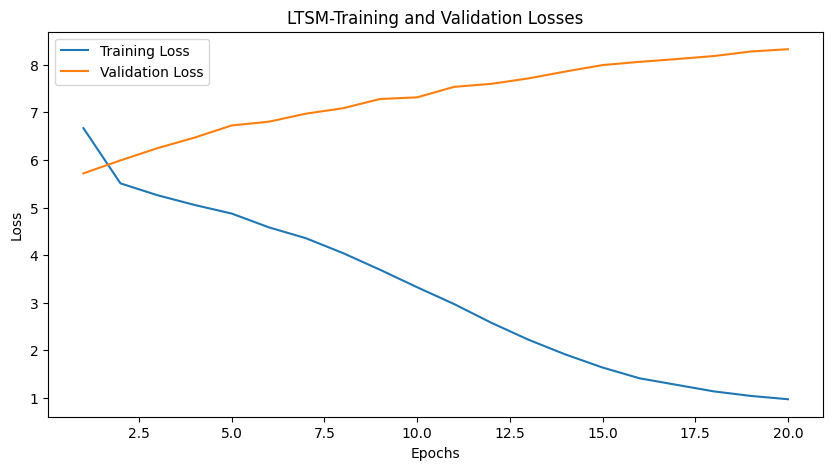

In [32]:
# Plotting Losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LTSM-Training and Validation Losses')
plt.legend()
plt.show()

In [40]:
def translate_new_sentence(model, input_sentence, input_vocab, output_vocab, max_len=MAX_LEN):
    """
    Translate a new sentence from input language to output language.
    """
    model.eval()
    input_tensor = sentence_to_tensor(input_sentence, input_vocab, max_len).unsqueeze(0).to(DEVICE)

    # Start with the <s> token as input to the decoder
    output_input = torch.tensor([output_vocab['<s>']]).unsqueeze(0).to(DEVICE)

    translated_tokens = []
    with torch.no_grad():
        for _ in range(max_len):
            output = model(input_tensor, output_input)
            output_token = output.argmax(dim=-1)[:, -1].item()  # Get the most likely next token

            if output_token == output_vocab['</s>']:  # End token
                break

            translated_tokens.append(output_token)

            # Update the input for the next time step
            output_input = torch.cat([output_input, torch.tensor([[output_token]]).to(DEVICE)], dim=1)

    # Convert token IDs back to words
    translated_sentence = " ".join([k for k, v in output_vocab.items() if v in translated_tokens])

    # Wrap the output in the desired format
    return translated_sentence.strip()


def translate_and_format(model, input_sentence, input_vocab, output_vocab, direction, max_len=MAX_LEN):
    """
    Wrapper function to format the translation output.
    """
    translated_sentence = translate_new_sentence(model, input_sentence, input_vocab, output_vocab, max_len)
    return f"<s>\n<{direction[0]}> {input_sentence.strip()} </{direction[0]}>\n<{direction[1]}> {translated_sentence} </{direction[1]}>\n</s>"


# Test translation
en_example_sentence = "who are you."
ja_example_sentence = "あなたは誰ですか."

# English to Japanes
translated_bu_sentence = translate_and_format(model, en_example_sentence, en_vocab, ja_vocab, direction=("en", "ja"))
print(translated_bu_sentence)

# Japanes to English
translated_en_sentence = translate_and_format(model, ja_example_sentence, ja_vocab, en_vocab, direction=("ja", "en"))
print(translated_en_sentence)


<s>
<en> who are you. </en>
<ja> × </ja>
</s>
<s>
<ja> あなたは誰ですか. </ja>
<en> develop. </en>
</s>


In [41]:
def translate_new_sentence(model, sentence, src_vocab, tgt_vocab, max_len=50):
    model.eval()
    en_indices = [src_vocab.get(word, src_vocab['<unk>']) for word in sentence.split()]
    en_tensor = torch.tensor(en_indices).unsqueeze(0).to(DEVICE)
    tgt_tensor = torch.tensor([tgt_vocab['<s>']]).unsqueeze(0).to(DEVICE)
    translated_sentence = []

    for _ in range(max_len):
        with torch.no_grad():
            output = model(en_tensor, tgt_tensor)

        output_token = output.argmax(dim=-1)[:, -1]
        output_token_item = output_token.item()
        translated_word = list(tgt_vocab.keys())[list(tgt_vocab.values()).index(output_token_item)]
        translated_sentence.append(translated_word)

        if translated_word == '</s>':
            break

        tgt_tensor = torch.cat((tgt_tensor, output_token.unsqueeze(0)), dim=-1)

    return ' '.join(translated_sentence)

def calculate_bleu_chrf(en_sentences, te_sentences, model, en_vocab, te_vocab, max_len=50):
    bleu_scores, chrf_scores = [], []

    for en_sentence, te_sentence in zip(en_sentences, bu_sentences):
        translated_sentence = translate_new_sentence(model, en_sentence, en_vocab, bu_vocab, max_len)

        # Calculate BLEU Score without smoothing
        bleu_score = sacrebleu.corpus_bleu([translated_sentence], [[te_sentence]]).score
        bleu_scores.append(bleu_score)

        # Calculate CHRF Score without smoothing
        chrf_score = sacrebleu.corpus_chrf([translated_sentence], [[te_sentence]]).score
        chrf_scores.append(chrf_score)

    return bleu_scores, chrf_scores

lstm_bleu_scores, lstm_chrf_scores = calculate_bleu_chrf(en_sentences, ja_sentences, model, en_vocab, ja_vocab)

# Save BLEU scores to CSV
with open('Seq2Seq_BLEU_scores11.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["BLEU Score"])  # Only BLEU score
    for bleu in lstm_bleu_scores:
        writer.writerow([bleu])  # Just the BLEU score

# Save CHRF scores to CSV
with open('Seq2Seq_CHRF_scores1.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["CHRF Score"])  # Only CHRF score
    for chrf in lstm_chrf_scores:
        writer.writerow([chrf])  # Just the CHRF score

print("BLEU and CHRF scores saved to CSV files.")

BLEU and CHRF scores saved to CSV files.


In [46]:
import pandas as pd

# Load the BLEU scores CSV file
bleu_scores_path = 'Seq2Seq_BLEU_scores11.csv'
bleu_df = pd.read_csv(bleu_scores_path)

# Load the CHRF scores CSV file
chrf_scores_path = 'Seq2Seq_CHRF_scores1.csv'
chrf_df = pd.read_csv(chrf_scores_path)

# Display the first few rows of both files to understand their structure
bleu_df.head(), chrf_df.head()


(   BLEU Score
 0         0.0
 1         0.0
 2         0.0
 3         0.0
 4         0.0,
    CHRF Score
 0         0.0
 1         0.0
 2         0.0
 3         0.0
 4         0.0)

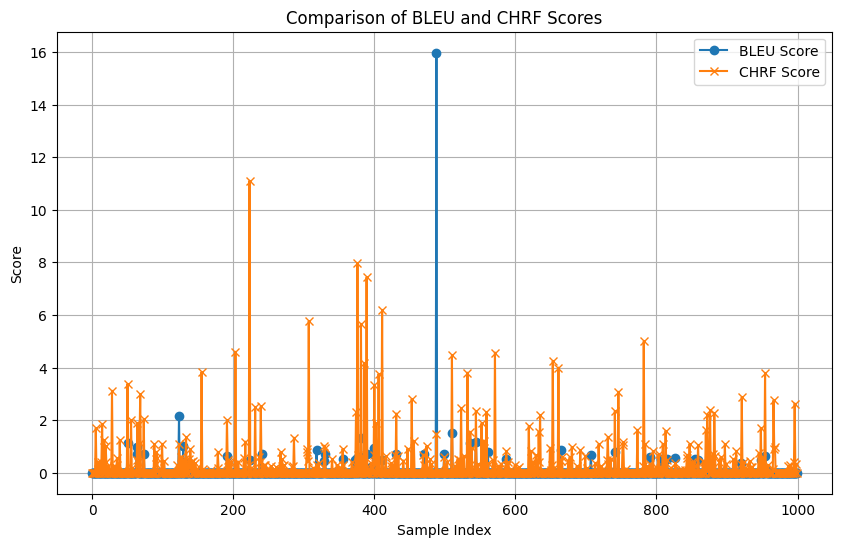

In [47]:


# Plotting the BLEU and CHRF scores
plt.figure(figsize=(10, 6))
plt.plot(bleu_df['BLEU Score'], label='BLEU Score', marker='o')
plt.plot(chrf_df['CHRF Score'], label='CHRF Score', marker='x')

# Adding labels and title
plt.xlabel('Sample Index')
plt.ylabel('Score')
plt.title('Comparison of BLEU and CHRF Scores')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

